In [2]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial import distance as dist

In [3]:
test = cv2.imread("Test/Test.Bmp", 0) 
draw = cv2.imread("Test/Draw.jpg", 0) 

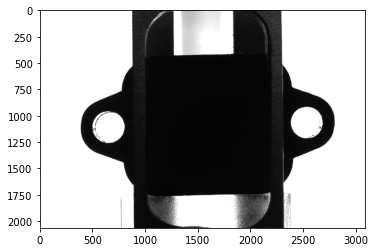

In [5]:
plt.imshow(test,cmap='gray', vmin=0, vmax=255)
plt.show()

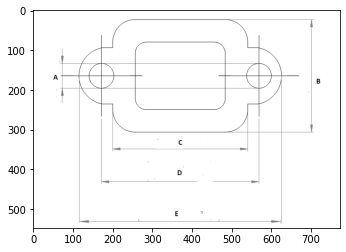

In [6]:
plt.imshow(draw,cmap='gray', vmin=0, vmax=255)
plt.show()

## Calculations

### To Find:

* A, B, C, D, E

### Solution:
A = 2 x radius of circle  
B = Bounding Box width for complete object  
C = D - A   ( D - 2 x radius of circle)  assumption that circles are tangent to perpendicular drawn from C's end point  
D = Distance between center of two circles  
E = Bounding Box length for complete object

In [7]:
test.shape

(2064, 3088)

In [8]:
def detect_circles(image):
    gray = cv2.GaussianBlur(image, (5, 5), 0)
    detected_circles = cv2.HoughCircles(gray,  
                   cv2.HOUGH_GRADIENT, 1, minDist = 1500, param1 = 50, 
               param2 = 30, minRadius = 50, maxRadius = 200)
    height, width = image.shape[0], image.shape[1]
    result = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if detected_circles is not None: 
        # Convert the circle parameters a, b and r to integers. 
        detected_circles = np.uint16(np.around(detected_circles)) 

        for pt in detected_circles[0, :]: 
            a, b, r = pt[0], pt[1], pt[2] 
            print(f"Circle found! Centre point coordinates: ({a}, {b}) and radius: {r}")
            # Draw the circumference of the circle. 
            result = cv2.circle(result, (a, b), r, (0, 255, 0), 15)
    return result


Circle found! Centre point coordinates: (2526, 1066) and radius: 150
Circle found! Centre point coordinates: (650, 1108) and radius: 151


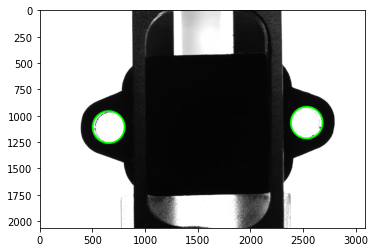

In [9]:
result = detect_circles(test)
plt.imshow(result)
plt.show()

In [10]:
a = (2526, 1066)
b = (650, 1108)
D =  dist.euclidean(a, b)
radius = (150 + 151)/2
A = 2*radius
C = D - A
print(f'Dimensions are, A:{A}, C:{C}, D:{D}')

Dimensions are, A:301.0, C:1575.4700903558255, D:1876.4700903558255


## Found: A, C, D  
* A: 301.0
* C: 1575.4700903558255
* D: 1876.4700903558255

### Distance A = 301, C = 1575, D = 1876

### To find B, E

* B = Distance between two horizontal parallel points
* E = Distance between two extreame points (left and right)

In [179]:
def midpoint(ptA, ptB):
    return ((ptA[0] + ptB[0]) * 0.5, (ptA[1] + ptB[1]) * 0.5)

def getSlopeOfLine(line):
    xDis = line[0][2] - line[0][0]
    if (xDis == 0):
        return None
    return (line[0][3] - line[0][1]) / xDis

def detect_line_segment(img):
    fld = cv2.ximgproc.createFastLineDetector(_length_threshold = 50, _do_merge = True)
    lines_all = fld.detect(img)
#     height, width = img.shape[0], img.shape[1]
    result = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    lines = []
    parallelLines = []
    for l in lines_all:
        [x0, y0, x1, y1] = map(int, list(l.flatten()))
        if dist.euclidean((x0, y0), (x1, y1)) > 100:
            lines.append(l)
    
    for a in lines:
        for b in lines:
            if a is not b:
                slopeA = getSlopeOfLine(a)
                slopeB = getSlopeOfLine(b)
                if slopeA is not None and slopeB is not None:
                    if 0 <= abs(slopeA - slopeB) <= 0.1:
                        a_points = list(map(int, list(a.flatten())))
                        b_points = list(map(int, list(b.flatten())))
                        a_mid =  midpoint((a_points[0], a_points[1]), (a_points[2], a_points[3]))
                        b_mid =  midpoint((b_points[0], b_points[1]), (b_points[2], b_points[3]))
                        distance = dist.euclidean(a_mid, b_mid)
                        if distance > 1000 and distance < 1500:
                            parallelLines.append([a, b])
                        
    for pair in parallelLines:
        for l in pair:
            [x0, y0, x1, y1] = map(int, list(l.flatten()))
            cv2.line(result, (x0, y0), (x1,y1), 255, 40, cv2.LINE_AA)
    return result, parallelLines

In [180]:
result, parallelLines = detect_line_segment(test)

In [181]:
parallelLines

[[array([[1271.047 ,  430.0091, 1749.9773,  418.1189]], dtype=float32),
  array([[1831.0225, 1747.5378, 1361.9841, 1754.7356]], dtype=float32)],
 [array([[1831.0225, 1747.5378, 1361.9841, 1754.7356]], dtype=float32),
  array([[1271.047 ,  430.0091, 1749.9773,  418.1189]], dtype=float32)]]

In [182]:
getSlopeOfLine(parallelLines[0][0]), getSlopeOfLine(parallelLines[0][1])

(-0.024826573, -0.015345769)

### The slope of two lines is approximately same so we can assume to be parallel

In [183]:
line_1 = parallelLines[0][0][0].tolist()
line_2 = parallelLines[0][1][0].tolist()
print(f"Upper line co-ordinates: {line_1}")
print(f"lower line co-ordinates: {line_2}")

Upper line co-ordinates: [1271.0469970703125, 430.00909423828125, 1749.977294921875, 418.118896484375]
lower line co-ordinates: [1831.0224609375, 1747.537841796875, 1361.984130859375, 1754.735595703125]


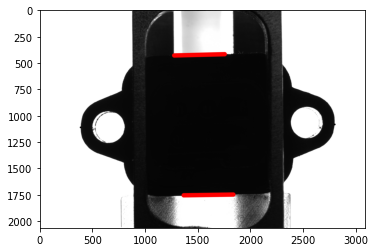

In [184]:
plt.imshow(result)
plt.show()

Notes:  
line_1 upper_line  
line_2: lower_line  

Point:  
line_1[0,1] = top_left  
line_1[2,3] = top_right  
line_2[0,1] = bottom_right  
line_2[2,3] = bottom_left  

let:   
p1 = top_left  
p2 = top right  
p3 = bottom_left  

In [185]:
p1=np.array([line_1[0], line_1[1]])
p2=np.array([line_1[2], line_1[3]])
p3=np.array([line_2[2], line_2[3]])
d=np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
print(f"Approximate parallel distance between them: {d}")

Approximate parallel distance between them: 1326.575398639362


### Distance B: 1327

In [186]:
def find_extremes(img):
    blur = cv2.GaussianBlur(img, (3,3), 0)
    thresh = cv2.threshold(blur, 220, 255, cv2.THRESH_BINARY_INV)[1]

    x, y, w, h = cv2.boundingRect(thresh)           #  Replaced code
                                                    #
    left = (x, np.argmax(thresh[:, x]))             # 
    right = (x+w-1, np.argmax(thresh[:, x+w-1]))    # 
    result = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    cv2.circle(result, left, 30, (255, 0, 0), -1)
    cv2.circle(result, right, 30, (255, 0, 0), -1)
    return result, left, right

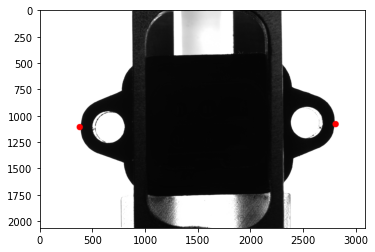

In [187]:
result, left, right = find_extremes(test)
plt.imshow(result)
plt.show()

In [188]:
d = dist.euclidean(left, right)
print(f"distance between two extremes: {d}")

distance between two extremes: 2424.161710777563


### Distance E: 2424


# Final Solution

### Approximate distances in pixel are:  
  
* A = 301
* B = 1327
* C = 1575
* D = 1876
* E = 2424